## Custom camera projection

User defined ray distribution tuned to read the face id info with a high performance.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

import numpy as np
from plotoptix import NpOptiX

Setup the raytracer:

In [2]:
width = 800
height = 500

def update_image(rt: NpOptiX) -> None:
    f = rt._geo_id[:,:,1].reshape(rt._height, rt._width)
    f1 = np.amax(f[f < 0xFFFFFFFF]) # skip id of empty regions
    f0 = np.amin(f)
    img.set_data(f) # update figure using face id data
    img.set_clim(vmin=f0, vmax=f1)
    plt.draw()

rt = NpOptiX(on_launch_finished=update_image, width=width, height=height, start_now=False)

# NOTE: no need for multiple passes if only the face id is needed, so set up just 1 pass:
rt.set_param(min_accumulation_step=1,
             max_accumulation_frames=1)

Read the mesh. Use a simple, flat shading material if the face id is the only interesting thing (so no secondary rays are traced).

In [3]:
from plotoptix.materials import m_flat

rt.setup_material("flat", m_flat)

rt.load_mesh_obj("data/utah-teapot.obj", mat="flat")

Custom projection is defined with ray angles in a texture. If the texture size coincides with the render view size, each ray is exactly defined by corresponding pixel in the texture, otherwise ray angles are interpolated. Ray angles are:
- u, horizontal deflection with respect to the camera axis (negative to the left, positive to the right)
- v, vertical deflection with respect to the camera axis (negative down, positive up).

Angles are in radians, scaled to map the range `(-pi;  pi)` to `(-1; 1)`.

In [4]:
fov = 25 # field of view (vertical), in degrees

# equirectangular projection
a_ratio = width / height
u = np.linspace(-0.5 * a_ratio * fov / 180, 0.5 * a_ratio * fov / 180, width)
v = np.linspace(0.5 * fov / 180, -0.5 * fov / 180, height)

V, U = np.meshgrid(v, u)

fi_tex = np.stack((U, V)).T

rt.set_texture_2d("fi_tex", fi_tex)

Setup camera:

In [5]:
rt.setup_camera("cam1", cam_type="CustomProj",
                eye=[20, 40, 100],
                target=[0, 0, 0],
                up=[0.0, 1.0, 0.0],
                fov=23,
                textures=["fi_tex"])

Show the output image here:

<IPython.core.display.Javascript object>


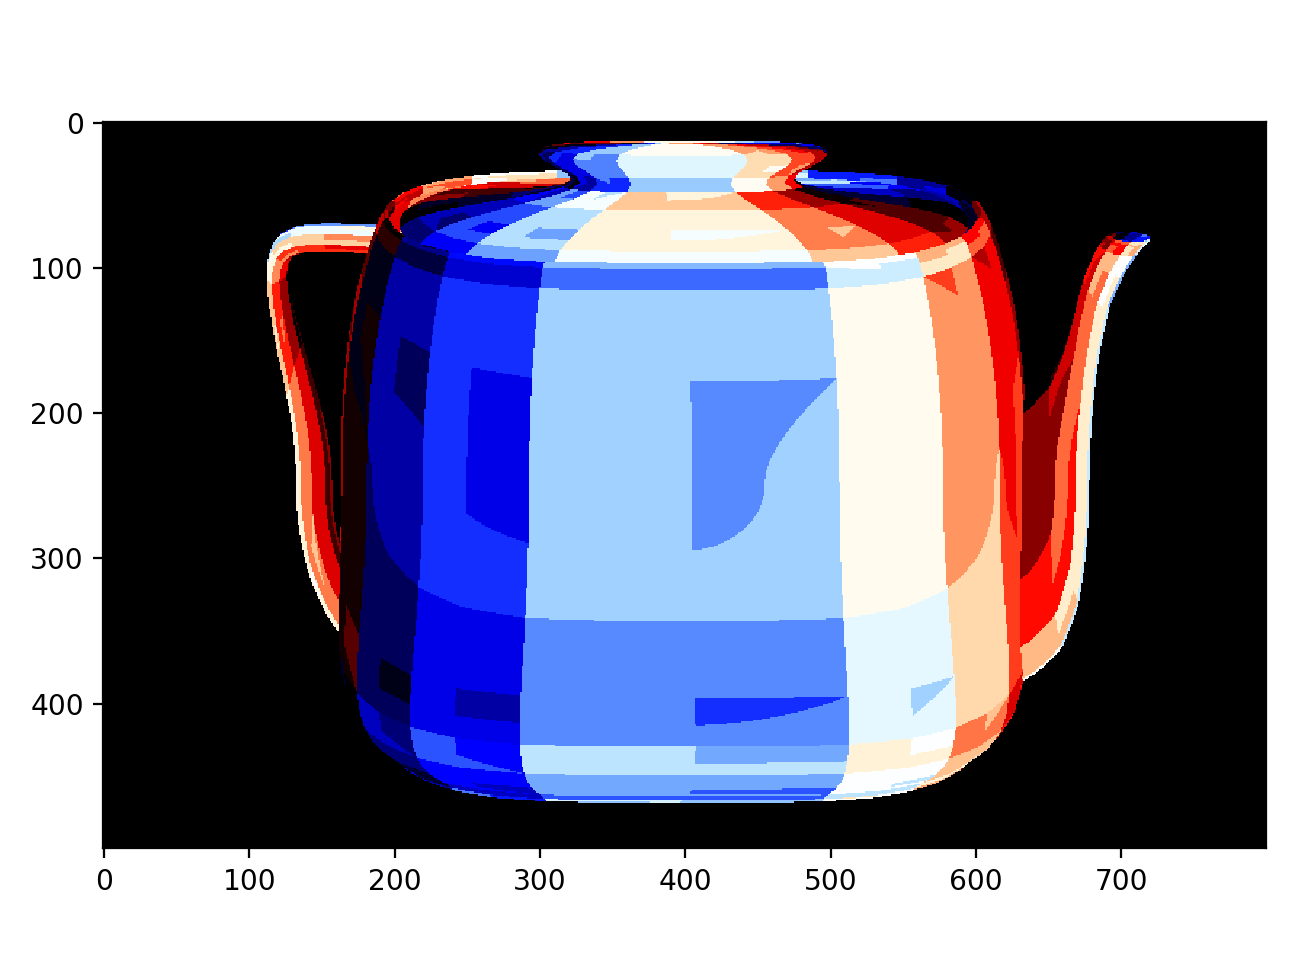

In [6]:
plt.figure(1)
img = plt.imshow(np.zeros((height,width,4)), cmap=plt.get_cmap("flag"))
plt.tight_layout()

Start the ray tracing:

In [7]:
rt.start()

Modify the projection angles :)

In [8]:
fi_tex2 = 10*np.multiply(np.sign(fi_tex), np.multiply(fi_tex, fi_tex))

rt.set_texture_2d("fi_tex", fi_tex2, refresh=True) # update texture content, data is copied directly to the device memory here

Close the ray-tracer.

In [9]:
rt.close()